In [1]:
import Pkg
Pkg.activate("../scripts/Project.toml")

 Activating environment at `~/Clones/SmartMonitoringSchemes/LargeScaleAnalysis/scripts/Project.toml`


In [5]:
using Dates
using PyPlot
import Distributions: Distribution, MixtureModel

# sns = Seaborn.seaborn
# color_palette = sns.color_palette

function publication_style(;fontsize=16)
    rc("axes", grid=true, titlesize=fontsize, xmargin=0, ymargin=0)
    rc("axes.grid", which="both")
    rc("figure", dpi=72)
    rc("font", size=fontsize)
    rc("grid", alpha=0.5, linestyle="--")
    rc("legend", frameon=false)
    # rc("lines", linewidth=1.0)
    rc("font", family = "serif", serif = ["Palatino"])
    rc("text", usetex = true)
end

# Returns the contiguous segments in `seq` (start, stop)
function getsegments(seq)
    idxs = findall(seq[2:end] .!= seq[1:end-1])
    idxs = vcat([0], idxs, [length(seq)])
    collect(zip(idxs[1:end-1] .+ 1, idxs[2:end]))
end

# Returns the length of the contiguous segments in `seq`
function getdurations(seq)
    idxs = findall(seq[2:end] .!= seq[1:end-1])
    idxs = vcat([0], idxs, [length(seq)])
    idxs[2:end] .- idxs[1:end-1]
end

function getcmap(seq)
    Dict(i => plt.cm.tab20(i) for i in sort(unique(seq)))
end

function relabel(seq)
    states = unique(seq)
    mapping = Dict(x[2] => x[1] for x in enumerate(states))
    [mapping[x] for x in seq]
end

function plotrtt(ts, seq = nothing; ax = gca())
    dates = unix2datetime.(ts.timestamp)
    ax.plot(dates, coalesce.(ts.min, NaN))
    if seq !== nothing
        cmap = getcmap(seq)
        segments = getsegments(seq)
        for segment in segments
            state = seq[segment[1]]
            start, stop = dates[collect(segment)]
            ax.axvspan(start, stop, alpha = 0.3, color = cmap[state])
        end
    end
end

function plotpdf(m::MixtureModel; ax = gca())
    xmin = minimum([c.μ - 6*c.σ for c in m.components])
    xmax = maximum([c.μ + 6*c.σ for c in m.components])
    supp = range(xmin, xmax, length = 1000)
    totpdf = zeros(size(supp))
    for (i, (c, p)) in enumerate(zip(m.components, m.prior.p))
        color = sns.color_palette("tab10", length(m.components))[i]
        y = p*pdf.(c, supp)
        totpdf += y
        ax.plot(supp, y, color = color, lw = 1.0)
        ax.fill_between(supp, y, color = color, alpha = 0.1)
    end
    ax.plot(supp, totpdf, color = "black", lw = 1.0)
end

function plotpdf(ms::Vector{<:Distribution})
    fig, axes = subplots(ncols = length(ms), figsize = (14,3))
    for (ax, m) in zip(axes, ms)
        plotpdf(m, ax = ax)
    end
end

plotpdf (generic function with 2 methods)

In [32]:
using ConjugatePriors: NormalInverseChisq
using Distributions
using Glob
using HDPHMM
using HMMBase
using JSON
using Missings
using ModelsIO
using ProgressMeter
using PyPlot
using Random

function prior(data)
    obs_med, obs_var = robuststats(Normal, data)
    tp = TransitionDistributionPrior(
        Gamma(2, 10),
        Gamma(100, 10),
        Beta(500, 1)
    )
    op = DPMMObservationModelPrior{Normal}(
        NormalInverseChisq(obs_med, obs_var, 1, 10),
        Gamma(1, 0.5)
    )
    BlockedSamplerPrior(1.0, tp, op)
end

function prepare(results; interval = 240)
    index, data = Int64[], allowmissing(Float64[])
    for result in results
        push!(index, result["timestamp"])
        push!(data, result["min"] > 0 ? result["min"] : missing)
    end
    resample_interval(index, data, 240)
end

function infer(data; L = 15, LP = 5)
    config = MCConfig(
        init = KMeansInit(L),
        iter = 100,
        verb = true
    )
    chains = HDPHMM.sample(BlockedSampler(L, LP), prior(data), data, config = config)
end

function process(file)
    Random.seed!(2020)
    @info "Processing $file"
    results = load(Vector{Dict}, file)
    index, data = prepare(results)
    index, data, infer(data)
end

process (generic function with 1 method)

In [33]:
HDPHMM.enablemissing(1.0)

In [34]:
index, data, chain = process("../data/ping_v4_1580511600_1581116400_noself_pairs/18724672_6373.ndjson");

K-means converged with 11 iterations (objv = 17.945027973561082)


┌ Info: Processing ../data/ping_v4_1580511600_1581116400_noself_pairs/18724672_6373.ndjson
└ @ Main In[32]:47


[HDPHMM #1] Chain 1 Iteration 100
[HDPHMM #1] Chain 1 Iteration 200
[HDPHMM #1] Chain 1 Iteration 300
[HDPHMM #1] Chain 1 Iteration 400
[HDPHMM #1] Chain 1 Iteration 500
[HDPHMM #1] Chain 1 Iteration 600
[HDPHMM #1] Chain 1 Iteration 700
[HDPHMM #1] Chain 1 Iteration 800
[HDPHMM #1] Chain 1 Iteration 900
[HDPHMM #1] Chain 1 Iteration 1000


In [35]:
struct Tmp2
    timestamp
    min
end

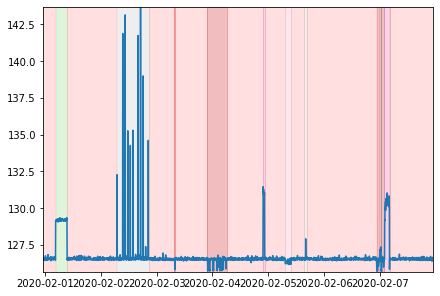

In [31]:
plotrtt(Tmp2(index, data), chain[1].zseqs[end,:])

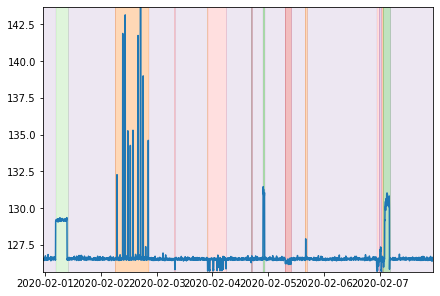

In [36]:
plotrtt(Tmp2(index, data), chain[1].zseqs[end,:])

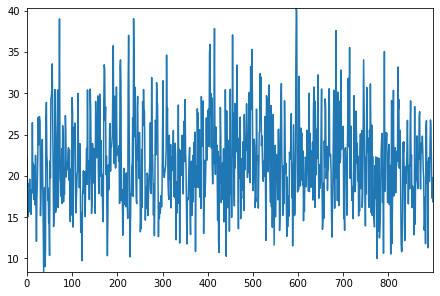

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1c0355ff50>

In [127]:
plot(map(x -> x.transdist.α, chain[1].states))

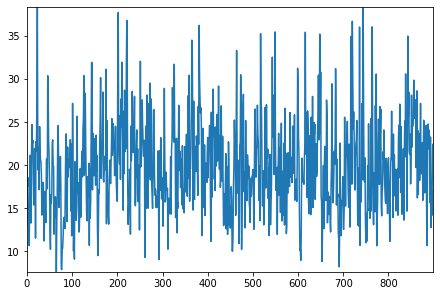

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1befe9ec50>

In [45]:
plot(map(x -> x.transdist.α, chain[1].states))

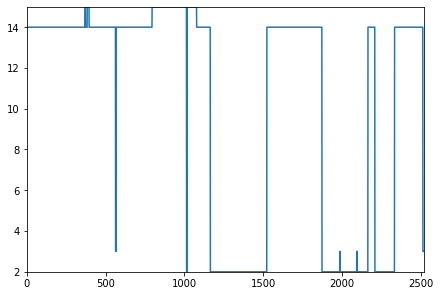

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1c03b788d0>

In [128]:
plot(chain[1].zseqs[end,:])

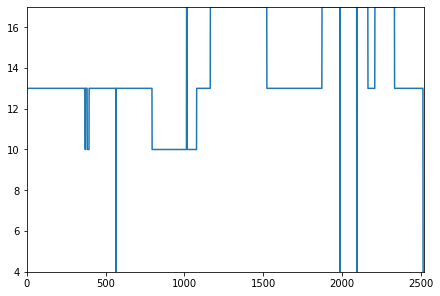

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1befe36790>

In [100]:
plot(chain[1].zseqs[end,:])

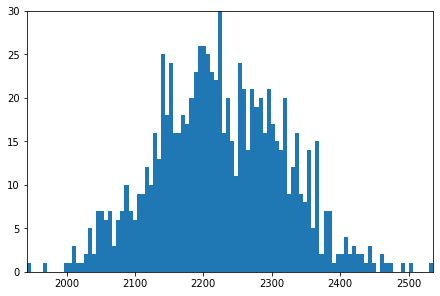

In [129]:
hist(map(x -> x.transdist.α + x.transdist.κ, chain[1].states), bins=100);

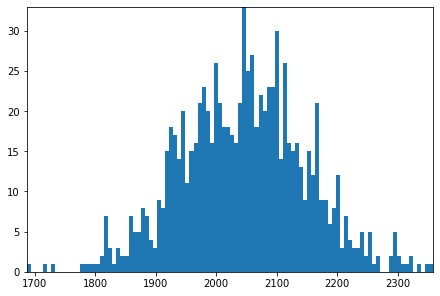

In [37]:
hist(map(x -> x.transdist.α + x.transdist.κ, chain[1].states), bins=100);

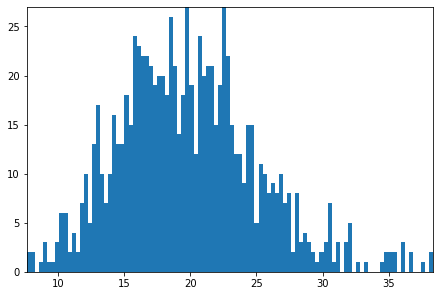

In [77]:
hist(map(x -> x.transdist.α, chain[1].states), bins=100);

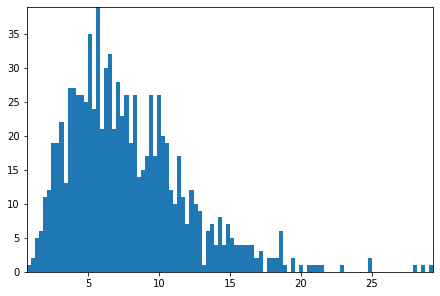

In [130]:
hist(map(x -> x.transdist.γ, chain[1].states), bins=100);

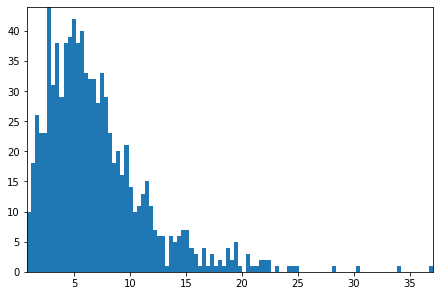

In [33]:
hist(map(x -> x.transdist.γ, chain[1].states), bins=100);

In [93]:
L = 15
rand(Dirichlet(0.1*rand(Dirichlet(L, 1))))

15-element Array{Float64,1}:
 0.9935219951024009
 8.843124297741622e-129
 0.0
 6.722042097677278e-111
 5.861988308117358e-136
 5.832654186781646e-70
 3.232128516340002e-10
 9.38515586902922e-18
 0.0
 1.0791534459670834e-9
 0.0
 9.131035311755871e-47
 7.96408144194433e-74
 0.006478003495233081
 3.713918969544007e-265

In [119]:
rand(Gamma(2,10))

7.042365065141883

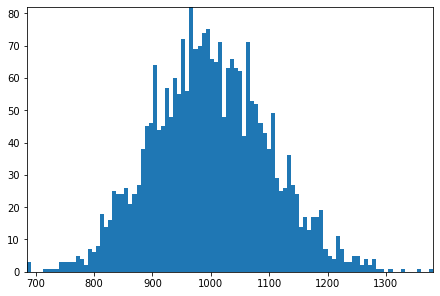

In [124]:
hist(rand(Gamma(100, 10), 2500), bins=100);

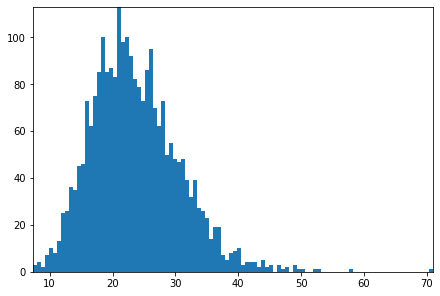

In [39]:
hist(rand(Gamma(12, 2), 2500), bins=100);

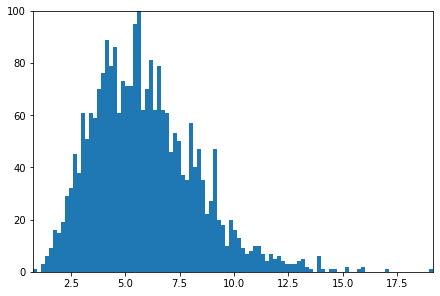

In [38]:
hist(rand(Gamma(6, 1), 2500), bins=100);